# Checkpoint 1: Disaster Tweets

**Outputs (saved under `results/`):**
- Figures: class balance, tweet length histogram, signal rates by class, top terms per class (LR weights), confusion matrix (best model)
- Tables: `signal_rates.csv`, `top_terms_disaster.csv`, `top_terms_nondisaster.csv`, `cv_results.csv`, `holdout_report.csv`

**Data:** Place Kaggle `train.csv` in a folder named `data/` alongside this notebook.

In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from scipy import sparse
from pathlib import Path

simplefilter('ignore', ConvergenceWarning)

SEED = 42

# Project paths
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "assets"
FIG_DIR = OUTPUT_DIR / "figures"

DATA_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"

print("Train path:", TRAIN_PATH, "| Exists:", TRAIN_PATH.exists())
print("Test path :", TEST_PATH,  "| Exists:", TEST_PATH.exists())
OUT_FIGS    = os.path.join('results','figs')
OUT_TABLES  = os.path.join('results','tables')
os.makedirs(OUT_FIGS, exist_ok=True)
os.makedirs(OUT_TABLES, exist_ok=True)
print('Ready — expecting:', DATA_DIR)

Train path: /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification/data/train.csv | Exists: True
Test path : /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification/data/test.csv | Exists: True
Ready — expecting: /Users/taljindersingh/Documents/Personal Space/ARIZONA STATE UNIVERSITY/19. GitHub/disaster-tweets-classification/data


## Minimal text normalization

In [2]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
ELONG_RE = re.compile(r'(\w)\1{2,}')

def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(' <url> ', s)
    s = MENTION_RE.sub(' <user> ', s)
    s = HASHTAG_RE.sub(lambda m: f' {m.group(1)} ', s)
    s = ELONG_RE.sub(r'\1\1', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def add_simple_signals(df, text_col='text'):
    def has_url(x): return 1 if URL_RE.search(x or '') else 0
    def has_mention(x): return 1 if MENTION_RE.search(x or '') else 0
    def has_hashtag(x): return 1 if '#' in (x or '') else 0
    out = df.copy()
    out['len_chars'] = out[text_col].astype(str).str.len()
    out['len_words'] = out[text_col].astype(str).str.split().str.len()
    out['has_url'] = out[text_col].astype(str).apply(has_url)
    out['has_mention'] = out[text_col].astype(str).apply(has_mention)
    out['has_hashtag'] = out[text_col].astype(str).apply(has_hashtag)
    out['has_keyword'] = out['keyword'].notna().astype(int) if 'keyword' in out.columns else 0
    return out

## Load data

In [3]:
df = pd.read_csv(TRAIN_PATH)
assert {'text','target'}.issubset(df.columns)
df['text_norm'] = df['text'].apply(normalize_text)
df = add_simple_signals(df)
df.head()

,id,keyword,location,text,target,text_norm,len_chars,len_words,has_url,has_mention,has_hashtag,has_keyword
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,69,13,0,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,38,7,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,133,22,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,00 people receive wildfires evacuation orde...",65,8,0,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,88,16,0,0,1,0


## EDA — Class balance

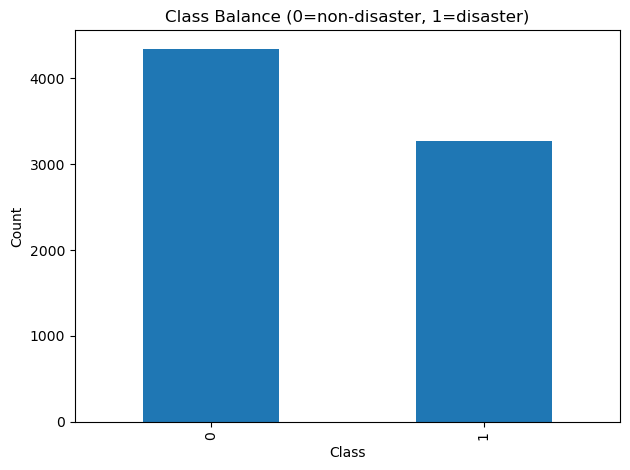

In [4]:
ax = df['target'].value_counts().sort_index().plot(kind='bar')
ax.set_title('Class Balance (0=non-disaster, 1=disaster)')
ax.set_xlabel('Class'); ax.set_ylabel('Count')
plt.tight_layout(); plt.savefig(os.path.join(OUT_FIGS,'class_balance.png')); plt.show()

## EDA — Tweet length (words)

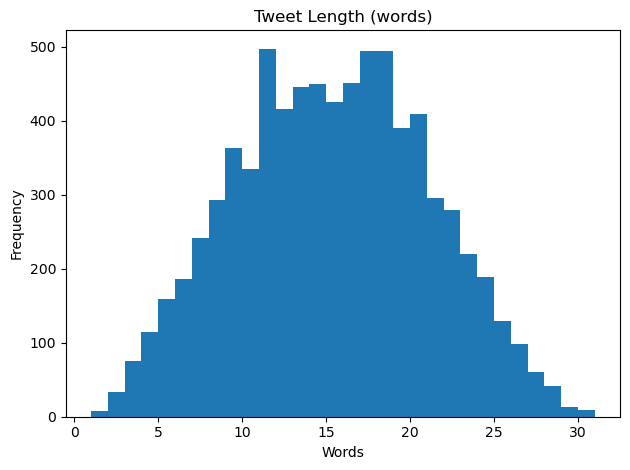

In [5]:
ax = df['len_words'].plot(kind='hist', bins=30)
ax.set_title('Tweet Length (words)')
ax.set_xlabel('Words'); ax.set_ylabel('Frequency')
plt.tight_layout(); plt.savefig(os.path.join(OUT_FIGS,'tweet_length_hist.png')); plt.show()

## EDA — Signal rates by class

,has_url,has_mention,has_hashtag,has_keyword
target,,,,
0,0.414325,0.309304,0.204053,0.995624
1,0.664017,0.203607,0.267502,0.987160


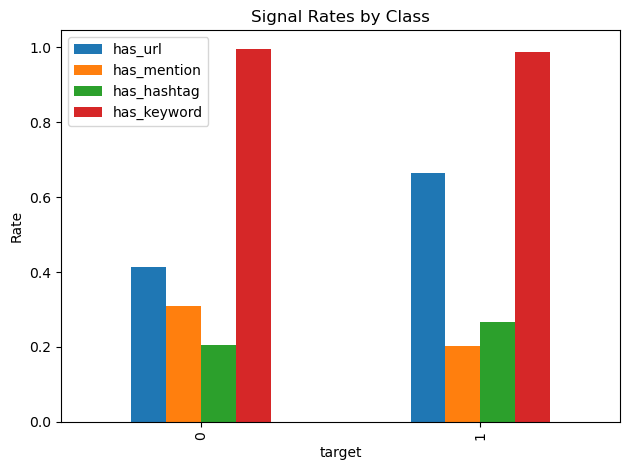

In [6]:
sig_cols = ['has_url','has_mention','has_hashtag','has_keyword','target']
rates = df[sig_cols].groupby('target').mean()
display(rates)
rates.to_csv(os.path.join(OUT_TABLES,'signal_rates.csv'))
rates.plot(kind='bar'); plt.title('Signal Rates by Class'); plt.ylabel('Rate')
plt.tight_layout(); plt.savefig(os.path.join(OUT_FIGS,'signal_rates.png')); plt.show()

## EDA — Directional top terms (per class) from Logistic Regression

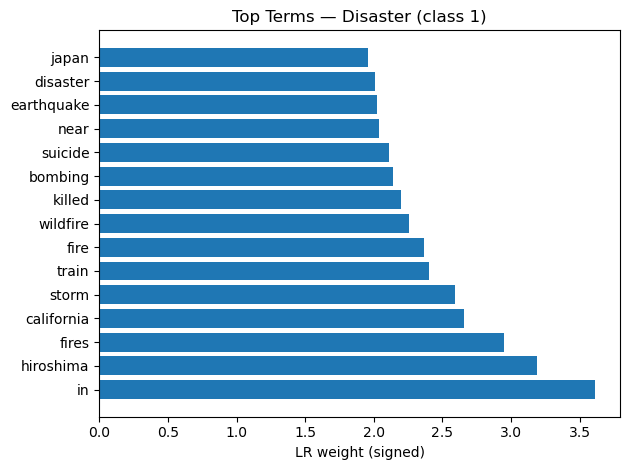

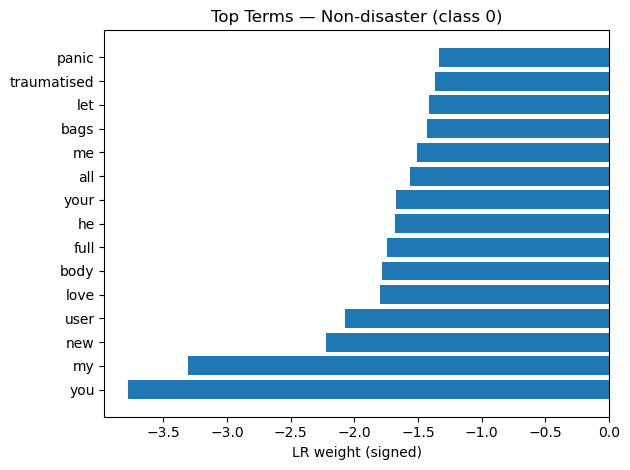

In [7]:
vect_word = TfidfVectorizer(ngram_range=(1,2), min_df=2, sublinear_tf=True)
Xw = vect_word.fit_transform(df['text_norm'])
y = df['target'].values
lr_for_terms = LogisticRegression(solver='liblinear', max_iter=4000)
lr_for_terms.fit(Xw, y)
feature_names = np.array(vect_word.get_feature_names_out())
coefs = lr_for_terms.coef_.ravel()

def top_k_by_sign(coefs, feature_names, k=15, positive=True):
    idx = np.argsort(coefs)
    sel = idx[-k:][::-1] if positive else idx[:k]
    return feature_names[sel], coefs[sel]

def save_top_terms_plot(terms, weights, fname, title):
    order = np.arange(len(terms))[::-1]
    plt.figure(); plt.barh(order, weights[::-1]); plt.yticks(order, terms[::-1])
    plt.title(title); plt.xlabel('LR weight (signed)')
    plt.tight_layout(); plt.savefig(os.path.join(OUT_FIGS,fname)); plt.show()

terms_pos, w_pos = top_k_by_sign(coefs, feature_names, k=15, positive=True)
pd.DataFrame({'term': terms_pos, 'weight': w_pos}).to_csv(os.path.join(OUT_TABLES,'top_terms_disaster.csv'), index=False)
save_top_terms_plot(terms_pos, w_pos, 'top_terms_disaster.png', 'Top Terms — Disaster (class 1)')

terms_neg, w_neg = top_k_by_sign(coefs, feature_names, k=15, positive=False)
pd.DataFrame({'term': terms_neg, 'weight': w_neg}).to_csv(os.path.join(OUT_TABLES,'top_terms_nondisaster.csv'), index=False)
save_top_terms_plot(terms_neg, w_neg, 'top_terms_nondisaster.png', 'Top Terms — Non-disaster (class 0)')

# Baselines — CV search + hold-out result

### Understanding the Output Files for Checkpoint 1

#### 1. `cv_results.csv` — Model Selection Table (via 5-Fold Cross Validation)

This file contains the **grid of all (features × model × hyperparameters)** combinations you tried.  

**Typical columns:**
- `features` — e.g., `word`, `char`, `word+char`, `word+char+meta`
- `model` — e.g., `LR` (Logistic Regression), `SVM` (Linear SVM), `CNB` (Complement Naive Bayes)
- **Hyperparameters** — e.g., `C`, `class_weight` (for LR/SVM); `alpha` (for NB)
- `f1_mean`, `f1_std` — Macro/Weighted F1 across the 5 folds (**primary metric**)
- `acc_mean`, `prec_mean`, `rec_mean` — Averaged Accuracy/Precision/Recall across folds

**How to read it:**
- Sort by `f1_mean` in descending order → **Top row = current best config** under CV.  
- Check `f1_std`:  
  - Low std ⇒ stable performance across folds  
  - High std ⇒ sensitive to data splits  
- Compare model families:  
  - Typically `word+char ≥ word ≥ char`  
  - `LR/SVM` often outperform `NB`  
  - `class_weight='balanced'` often improves performance

---

#### 2. `holdout_report.csv` — Final Model on a Fresh 20% Split

This file reports **final metrics for the single best CV configuration** evaluated on a **stratified hold-out set** (never seen during training).

**Columns:**
- `features`, `model`, and its **hyperparameters** (should match the top CV row)
- `f1`, `accuracy`, `precision`, `recall` — metrics on the hold-out set only

**How to use it:**
- Present this table **next to your confusion matrix** in CP-1 slides as the headline result.  
- Compare `f1 (hold-out)` vs. `f1_mean (CV)`:
  - If **hold-out ≈ CV**, model generalizes well ✅  
  - If **hold-out << CV**, possible overfit → try gentler `C`, higher `min_df`, or drop meta features ⚠️  
  - If **hold-out >> CV**, possible random luck → repeat to confirm 🎲

---

#### Why We Generate Both Files

- **`cv_results.csv`** → Ensures **fair model search** (k-fold CV reduces variance)  
- **`holdout_report.csv`** → Gives a **final unbiased estimate** for the chosen model — this is the number to **quote in Checkpoint 1**


/Users/taljindersingh/Applications/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/taljindersingh/Applications/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

,features,model,C,class_weight,f1_mean,f1_std,acc_mean,prec_mean,rec_mean,alpha
20,char,LR,2.0,balanced,0.767747,0.012786,0.806910,0.794427,0.742888,NaN
33,word+char,LR,1.0,balanced,0.765944,0.012835,0.806253,0.796557,0.737693,NaN
31,word+char,LR,0.5,balanced,0.765795,0.012184,0.805991,0.795898,0.737999,NaN
18,char,LR,1.0,balanced,0.765392,0.012440,0.804939,0.792124,0.740443,NaN
35,word+char,LR,2.0,balanced,0.765136,0.013956,0.804808,0.791987,0.740137,NaN
22,char,SVM,0.5,balanced,0.763738,0.012754,0.805070,0.796779,0.733409,NaN
48,word+char+meta,LR,1.0,balanced,0.761182,0.015290,0.799291,0.779418,0.744110,NaN
50,word+char+meta,LR,2.0,balanced,0.759427,0.014869,0.795483,0.768995,0.750536,NaN
34,word+char,LR,2.0,None,0.759175,0.012453,0.808616,0.826697,0.701921,NaN
16,char,LR,0.5,balanced,0.759149,0.011873,0.800341,0.788246,0.732188,NaN


,features,model,C,class_weight,f1,accuracy,precision,recall
0,char,LR,2.0,balanced,0.767424,0.80499,0.786517,0.749235


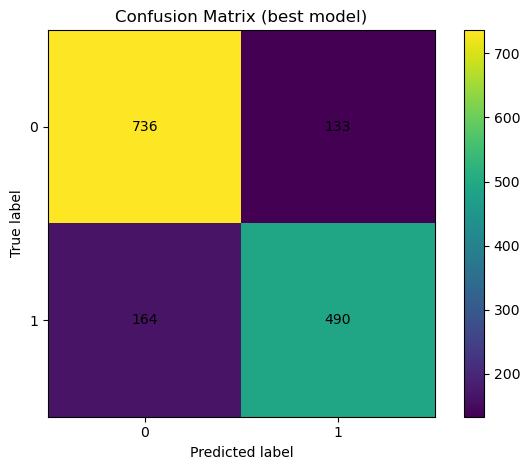


Best config: char LR {'C': 2.0, 'class_weight': 'balanced'}
Hold-out F1: 0.7674


In [8]:
from itertools import product
vect_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, sublinear_tf=True)
Xc = vect_char.fit_transform(df['text_norm'])
meta = df[['len_chars','len_words','has_url','has_mention','has_hashtag','has_keyword']].astype(float).values
Xm = sparse.csr_matrix(meta)

feature_sets = {
    'word': Xw,
    'char': Xc,
    'word+char': sparse.hstack([Xw, Xc]).tocsr(),
    'word+char+meta': sparse.hstack([Xw, Xc, Xm]).tocsr(),
}
models = {
    'LR': LogisticRegression(solver='liblinear', max_iter=4000, tol=1e-3),
    'SVM': LinearSVC(max_iter=20000, tol=1e-3),
    'CNB': ComplementNB(),
}
param_grid = {
    'LR':  {'C': [0.5, 1, 2], 'class_weight': [None, 'balanced']},
    'SVM': {'C': [0.5, 1, 2], 'class_weight': [None, 'balanced']},
    'CNB': {'alpha': [0.5, 1.0, 2.0]},
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rows = []
for f_name, X in feature_sets.items():
    for m_name, model in models.items():
        grid = param_grid[m_name]
        for params in (dict(zip(grid.keys(), v)) for v in product(*grid.values())):
            mdl = model.__class__(**params)
            scores = cross_validate(mdl, X, y, cv=cv,
                scoring=['f1','accuracy','precision','recall'], return_train_score=False, n_jobs=-1)
            rows.append({
                'features': f_name,
                'model': m_name,
                **params,
                'f1_mean': scores['test_f1'].mean(),
                'f1_std': scores['test_f1'].std(),
                'acc_mean': scores['test_accuracy'].mean(),
                'prec_mean': scores['test_precision'].mean(),
                'rec_mean': scores['test_recall'].mean(),
            })

cv_df = pd.DataFrame(rows).sort_values(['f1_mean'], ascending=False)
display(cv_df.head(10))
cv_df.to_csv(os.path.join(OUT_TABLES,'cv_results.csv'), index=False)

best = cv_df.iloc[0]
best_features = best['features']
best_model_name = best['model']
best_params = {k: best[k] for k in param_grid[best_model_name].keys()}

X_best = feature_sets[best_features]
X_train, X_val, y_train, y_val = train_test_split(X_best, y, test_size=0.2, stratify=y, random_state=SEED)
final_model = models[best_model_name].__class__(**best_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)

f1 = f1_score(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
prec, rec, _, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

holdout = pd.DataFrame([{'features': best_features, 'model': best_model_name, **best_params,
                         'f1': f1, 'accuracy': acc, 'precision': prec, 'recall': rec}])
display(holdout)
holdout.to_csv(os.path.join(OUT_TABLES, 'holdout_report.csv'), index=False)

cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(); im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=[0,1], yticks=[0,1], xticklabels=['0','1'], yticklabels=['0','1'],
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (best model)')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
plt.tight_layout(); plt.savefig(os.path.join(OUT_FIGS,'confusion_matrix_best.png')); plt.show()
print('\nBest config:', best_features, best_model_name, best_params)
print('Hold-out F1:', round(f1,4))

# Checkpoint 2 – Disaster Tweets: Improved Model
**Goal:** Improve upon CP1 baselines using stronger features, model selection, and calibrated ensembling to raise F1.

**What’s new vs CP1**
- Word+char TF‑IDF with tuned n‑grams
- Metadata features (URL/@/# flags, length, keyword)
- Model search over Logistic Regression (saga), Linear SVM (calibrated), ComplementNB
- Out‑of‑fold (OOF) probability stacking + threshold tuning for best macro F1
- Reproducible splits, CSV artifacts (`cv_results.csv`, `holdout_report.csv`)

## 1) Imports & configuration

In [9]:

import os, re, random, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix

RNG = 42
np.random.seed(RNG); random.seed(RNG)

# Paths are defined in the top config cell (PROJECT_ROOT / data / train.csv)
# This cell contains only imports, RNG, and model-related setup so it can be run after the top config without redefining TRAIN_PATH.
    


## 2) Load data

In [10]:

df = pd.read_csv(TRAIN_PATH)
df['text'] = df['text'].astype(str)
df['keyword'] = df['keyword'].astype(str)
y = df['target'].astype(int).values
print(df.head(2)); print(df['target'].value_counts())


   id keyword location                                               text  \
0   1     nan      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     nan      NaN             Forest fire near La Ronge Sask. Canada   

   target  
0       1  
1       1  
target
0    4342
1    3271
Name: count, dtype: int64


## 3) Normalize text and add metadata

In [11]:

import re
url_pat = re.compile(r'https?://\S+')
user_pat = re.compile(r'@\w+')
hash_pat = re.compile(r'#(\w+)')
multi_space = re.compile(r'\s+')

def normalize_text(s: str) -> str:
    s = s.lower()
    s = url_pat.sub(' URL ', s)
    s = user_pat.sub(' USER ', s)
    s = hash_pat.sub(lambda m: ' HASH ' + m.group(1), s)
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)
    s = re.sub(r'[^a-z0-9\s\-\_\#\@]', ' ', s)
    s = multi_space.sub(' ', s).strip()
    return s

def add_meta_cols(frame: pd.DataFrame) -> pd.DataFrame:
    f = frame.copy()
    f['has_url'] = frame['text'].str.contains(r'http[s]?://', regex=True).astype(int)
    f['has_mention'] = frame['text'].str.contains(r'@\w+', regex=True).astype(int)
    f['has_hash'] = frame['text'].str.contains(r'#\w+', regex=True).astype(int)
    f['n_words'] = frame['text'].str.split().apply(len)
    f['n_chars'] = frame['text'].str.len()
    f['keyword_norm'] = frame['keyword'].str.replace('%20',' ', regex=False).str.lower()
    return f

df_norm = df.copy()
df_norm['text_norm'] = df_norm['text'].apply(normalize_text)
df_norm = add_meta_cols(df_norm)


## 4) Feature engineering (word + char TF‑IDF, metadata, keyword one‑hot)

In [12]:

tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=2,
                             max_features=250000, strip_accents="unicode", sublinear_tf=True)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2,
                             max_features=200000, strip_accents="unicode", sublinear_tf=True)

text_word_pipe = Pipeline([('sel', FunctionTransformer(lambda X: X['text_norm'], validate=False)),
                           ('tfidf_w', tfidf_word)])
text_char_pipe = Pipeline([('sel', FunctionTransformer(lambda X: X['text_norm'], validate=False)),
                           ('tfidf_c', tfidf_char)])

meta_numeric = ['has_url','has_mention','has_hash','n_words','n_chars']
meta_pipe = Pipeline([('sel', FunctionTransformer(lambda X: X[meta_numeric], validate=False)),
                      ('sc', StandardScaler(with_mean=False))])

kw_pipe = Pipeline([('sel', FunctionTransformer(lambda X: X[['keyword_norm']], validate=False)),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])

features = FeatureUnion([('word', text_word_pipe),
                         ('char', text_char_pipe),
                         ('meta', meta_pipe),
                         ('kw', kw_pipe)])

X_all = df_norm[['text_norm','has_url','has_mention','has_hash','n_words','n_chars','keyword_norm']]
print("Feature union ready.")


Feature union ready.


## 5) Models to compare

In [13]:

lr = LogisticRegression(solver='saga', penalty='l2', C=2.0, max_iter=5000, n_jobs=-1, class_weight='balanced')
base_svc = LinearSVC(C=1.0, class_weight='balanced')
svc = CalibratedClassifierCV(estimator=base_svc, method='sigmoid', cv=3)
cnb = ComplementNB(alpha=0.3)
models = {'LR': lr, 'SVC_cal': svc, 'CNB': cnb}


## 6) 5‑fold CV, OOF probabilities, threshold tuning

In [14]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows = []
oof_store = {}

for name, clf in models.items():
    print(f"\n=== CV for {name} ===")
    oof_pred = np.zeros(len(X_all), dtype=float)

    for tr_idx, va_idx in skf.split(X_all, y):
        Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]
        pipe = Pipeline([('feats', features), ('clf', clf)])
        pipe.fit(Xtr, ytr)

        if hasattr(pipe.named_steps['clf'], 'predict_proba'):
            p = pipe.predict_proba(Xva)[:,1]
        elif hasattr(pipe.named_steps['clf'], 'decision_function'):
            dfc = pipe.named_steps['clf'].decision_function(pipe.named_steps['feats'].transform(Xva))
            p = 1/(1+np.exp(-dfc))
        else:
            p = pipe.predict(Xva).astype(float)

        oof_pred[va_idx] = p

    thr_grid = np.linspace(0.2, 0.8, 61)
    best_thr, best_f1 = 0.5, -1
    for thr in thr_grid:
        pred = (oof_pred >= thr).astype(int)
        f1 = f1_score(y, pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    print(f"Best OOF F1={best_f1:.4f} @ thr={best_thr:.3f}")

    oof_store[name] = {'proba': oof_pred, 'best_thr': float(best_thr), 'best_f1': float(best_f1)}
    cv_rows.append({'features':'word+char+meta+kw','model':name,'oof_best_f1':best_f1,'best_thr':best_thr})

cv_df = pd.DataFrame(cv_rows).sort_values('oof_best_f1', ascending=False)
cv_df.to_csv(os.path.join(DATA_DIR,'cv_results.csv'), index=False)
cv_df



=== CV for LR ===
Best OOF F1=0.7689 @ thr=0.480

=== CV for SVC_cal ===
Best OOF F1=0.7689 @ thr=0.480

=== CV for SVC_cal ===
Best OOF F1=0.7582 @ thr=0.470

=== CV for CNB ===
Best OOF F1=0.7582 @ thr=0.470

=== CV for CNB ===
Best OOF F1=0.7669 @ thr=0.420
Best OOF F1=0.7669 @ thr=0.420


,features,model,oof_best_f1,best_thr
0,word+char+meta+kw,LR,0.768900,0.48
2,word+char+meta+kw,CNB,0.766876,0.42
1,word+char+meta+kw,SVC_cal,0.758160,0.47


## 7) Ensemble and 15% holdout evaluation

In [15]:

Xtrain, Xhold, ytrain, yhold = train_test_split(X_all, y, test_size=0.15, random_state=42, stratify=y)

pipe_lr = Pipeline([('feats', features), ('clf', models['LR'])])
pipe_svc = Pipeline([('feats', features), ('clf', models['SVC_cal'])])
pipe_lr.fit(Xtrain, ytrain); pipe_svc.fit(Xtrain, ytrain)

proba_lr = pipe_lr.predict_proba(Xhold)[:,1] if hasattr(pipe_lr.named_steps['clf'], 'predict_proba') else None
proba_svc = pipe_svc.predict_proba(Xhold)[:,1]

proba_blend = 0.5*proba_lr + 0.5*proba_svc if proba_lr is not None else proba_svc
thr_final = float(np.median([oof_store['LR']['best_thr'], oof_store['SVC_cal']['best_thr']]))

ypred = (proba_blend >= thr_final).astype(int)
p, r, f1, _ = precision_recall_fscore_support(yhold, ypred, average='binary')
acc = (ypred == yhold).mean()
cm = confusion_matrix(yhold, ypred)

holdout = pd.DataFrame([{'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc, 'thr_final': thr_final}])
holdout.to_csv(os.path.join(DATA_DIR,'holdout_report.csv'), index=False)
print({'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc, 'thr_final': thr_final})
print("Confusion matrix:\n", cm)
holdout


{'precision': 0.7936170212765957, 'recall': 0.7596741344195519, 'f1': 0.7762747138397502, 'accuracy': 0.8117338003502627, 'thr_final': 0.4750000000000001}
Confusion matrix:
 [[554  97]
 [118 373]]


,precision,recall,f1,accuracy,thr_final
0,0.793617,0.759674,0.776275,0.811734,0.475
